# Predicting Apple Stock Prices with LSTM

The goal of this project is to develop a predictive model for forecasting the future stock prices of Apple Inc. using a Long Short-Term Memory (LSTM) neural network. LSTM is a type of recurrent neural network (RNN) that is well-suited for time series data analysis, making it ideal for capturing temporal dependencies in stock price data. By training an LSTM model on historical stock price data, we aim to generate accurate predictions of future stock prices, enabling investors and traders to make informed decisions.

Part 1. Import Libraries and Data Loading

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Load the Apple stock data from a CSV file and convert the 'Date' column to a datetime data type
df = pd.read_csv("AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Drop the 'Adj Close' column from the DataFrame
df.drop(["Adj Close"], axis=1, inplace = True)

# Display the first 10 rows of the DataFrame
display(df.head(10))

# Check if there is any missing value
df.isnull().sum()

,Date,Open,High,Low,Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,55574400


Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Part 2. Data Visualisation

2.1 Visualising the trends of the Apple stock price and trading volume on the same plot

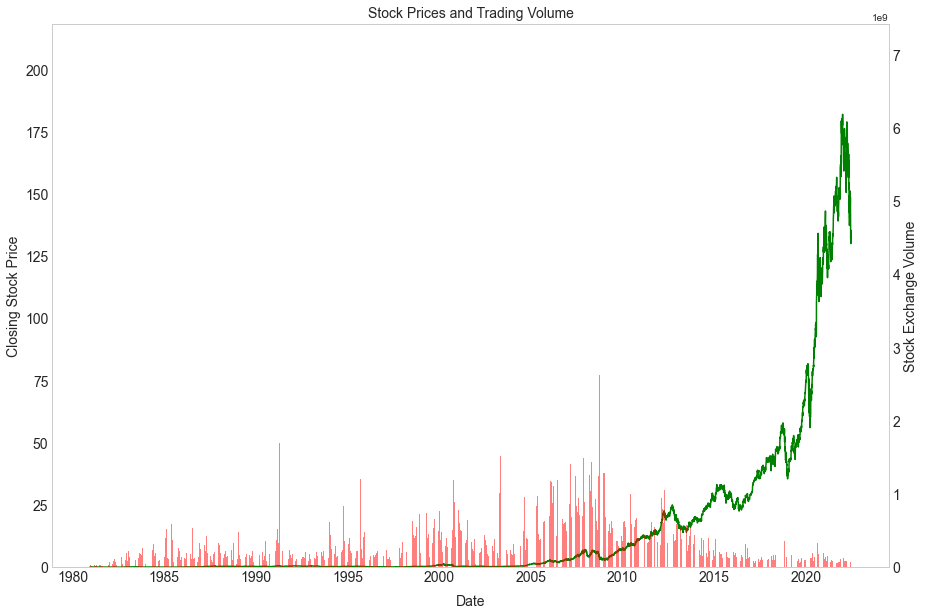

In [2]:
# Set the plot style
plt.style.use('seaborn-whitegrid')

# Create figure and axes objects
fig, ax1 = plt.subplots(figsize=(15, 10))

# Create line plot on primary axis
ax1.plot(df["Date"], df["Close"], color="green", label='stock price(close)', alpha=1)

# Set y-axis label and range for primary axis
ax1.set_ylabel("Closing Stock Price", fontsize=14)
ax1.set_ylim([0, df["Close"].max() * 1.2])

# Create bar chart on secondary axis
ax2 = ax1.twinx()
ax2.bar(df["Date"], df["Volume"], color="red", label='trading volume', alpha=0.5)

# Set y-axis label and range for secondary axis
ax2.set_ylabel("Stock Exchange Volume", fontsize=14)
ax2.set_ylim([0, df["Volume"].max()])

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

# Set the axis labels color and font size
ax1.set_xlabel('Date', fontsize=14, labelpad=10)
ax1.tick_params(axis='both', labelsize=14)
ax2.set_xlabel('Date', fontsize=14, labelpad=10)
ax2.tick_params(axis='both', labelsize=14)

# Set the plot title and font size
plt.title("Stock Prices and Trading Volume", fontsize=14)

# Show the plot
plt.show()

2.2 Normalising and plotting the stock prices dataset

['Date', 'Open', 'High', 'Low', 'Close']


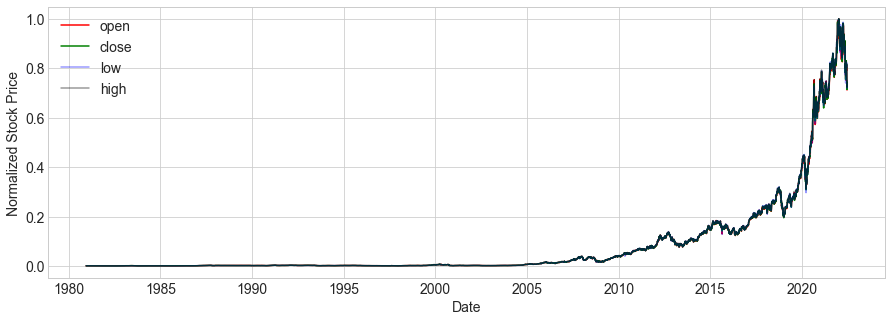

In [3]:
# Create a copy of the input dataframe
df_stock = df.copy()

# Drop the "Volume" column from the stock dataframe
df_stock.drop(labels=['Volume'], axis=1, inplace=True)

# Get the column names of the stock dataframe
cols = list(df_stock.columns.values)
print(cols)

# Normalise the stock prices using MinMaxScaler
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df_stock['Open'] = min_max_scaler.fit_transform(df_stock['Open'].values.reshape(-1,1))
df_stock['High'] = min_max_scaler.fit_transform(df_stock['High'].values.reshape(-1,1))
df_stock['Low'] = min_max_scaler.fit_transform(df_stock['Low'].values.reshape(-1,1))
df_stock['Close'] = min_max_scaler.fit_transform(df_stock['Close'].values.reshape(-1,1))

# Set figure style and size
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15, 5))

# Create line plot of normalized stock prices
plt.plot(df_stock["Date"], df_stock['Open'], color='red', label='open')
plt.plot(df_stock["Date"], df_stock['Close'], color='green', label='close')
plt.plot(df_stock["Date"], df_stock['Low'], color='blue', label='low', alpha=0.4)
plt.plot(df_stock["Date"], df_stock['High'], color='black', label='high', alpha=0.4)

# Set the x-axis and y-axis labels, legend and tick sizes
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized Stock Price', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.tick_params(axis='both', labelsize=14)

# Display the plot
plt.show()

Part 3. Model Building and Evaluation

3.1 Building an LSTM model with hyperparameter tuning

In [8]:
# Extract the relevant features (open, high, low, close) and normalize the data
features = df_stock[['Open', 'High', 'Low', 'Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Define the number of time steps and the number of features
time_steps = 30
num_features = 4

# Prepare the data for LSTM input
X = []
y = []
for i in range(time_steps, len(df_stock)):
    X.append(scaled_features[i - time_steps:i])
    y.append(scaled_features[i, 3])  # Close price is at index 3

X = np.array(X)
y = np.array(y)

# Make sure X and y have the same number of samples
X = X[:len(y)]

# Split the data into training and testing sets
train_size = int(0.8 * len(df_stock))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Define the LSTM model
def create_model(units):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(tf.keras.layers.LSTM(units=units))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrap the model in a KerasRegressor to use in the grid search
model = KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0)

# Define the grid search parameters
param_grid = {
    'model__units': [25, 50, 75]
}

# Perform the grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and mean squared error
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best mean squared error: {grid_result.best_score_:.4f}")

Best parameters: {'model__units': 50}
Best mean squared error: 0.4416


Result:

In the process of building an LSTM model with hyperparameter tuning, the best parameters obtained were {'model__units': 50}, and the corresponding best mean squared error achieved was 0.4416.

This result indicates that the LSTM model performed well with a hidden unit size of 50. The mean squared error of 0.4416 suggests that the model's predictions were, on average, 0.4416 units away from the actual values, indicating a relatively accurate prediction performance.

3.2 Building the LSTM model with the best parameters obtained from the grid search

In [10]:
# Build the LSTM model with the best parameters
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(time_steps, num_features)))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Training Loss: {train_loss}')
print(f'Testing Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test)

# Reshape the predictions array and y_test to match the number of features in the input data
predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1, num_features)

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(predictions.reshape(-1, num_features))[:, 3]
y_test = scaler.inverse_transform(y_test)[:, 3].flatten()

# Print the predicted and actual closing prices
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]:.2f} | Actual: {y_test[i]:.2f}')

Epoch 1/10
262/262 [==============================] - 9s 25ms/step - loss: 2.0343e-05
Epoch 2/10
262/262 [==============================] - 7s 25ms/step - loss: 2.2219e-06
Epoch 3/10
262/262 [==============================] - 6s 23ms/step - loss: 2.3589e-06
Epoch 4/10
262/262 [==============================] - 6s 23ms/step - loss: 1.9703e-06
Epoch 5/10
262/262 [==============================] - 6s 23ms/step - loss: 2.1658e-06
Epoch 6/10
262/262 [==============================] - 6s 22ms/step - loss: 1.7642e-06
Epoch 7/10
262/262 [==============================] - 6s 23ms/step - loss: 1.7888e-06
Epoch 8/10
262/262 [==============================] - 6s 23ms/step - loss: 1.5565e-06
Epoch 9/10
262/262 [==============================] - 6s 23ms/step - loss: 1.8950e-06
Epoch 10/10
262/262 [==============================] - 6s 23ms/step - loss: 1.5041e-06
Training Loss: 1.167763798548549e-06
Testing Loss: 0.0016577043570578098
65/65 [==============================] - 1s 7ms/step
Predicted: 0.

Result:
    
The training loss at the end of the training is approximately 1.17e-06, indicating that the model has learned to predict the training data with very low error. This suggests that the model has effectively captured the patterns and relationships present in the training data.

After training, the model is evaluated on the testing data, and the testing loss is calculated to be approximately 0.00166. The testing loss represents the error of the model's predictions on unseen data. A low testing loss indicates that the model is performing well on the testing data and is generalizing well to new examples.

Part 4. Visualisation of Stock Price Prediction Results

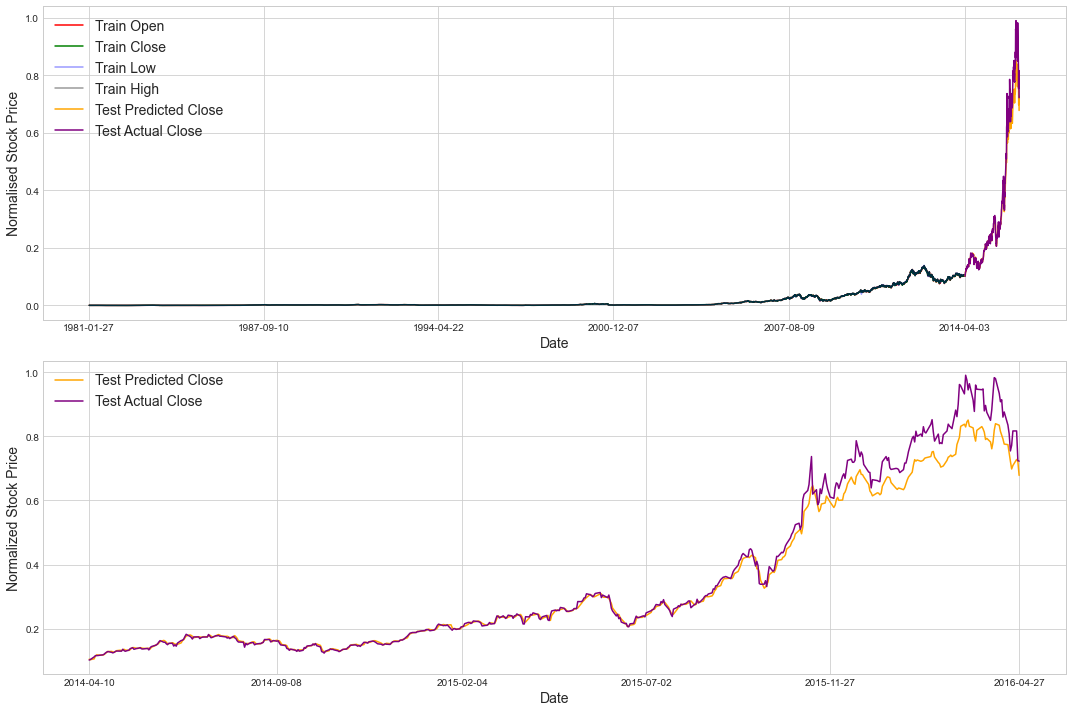

In [12]:
# Plot the datasets
plt.style.use('seaborn-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot the training data
x_train_pred = df_stock.iloc[time_steps:train_size + time_steps]['Date'].values
ax1.plot(x_train_pred, df_stock.iloc[time_steps:train_size + time_steps]['Open'], color='red', label='Train Open')
ax1.plot(x_train_pred, df_stock.iloc[time_steps:train_size + time_steps]['Close'], color='green', label='Train Close')
ax1.plot(x_train_pred, df_stock.iloc[time_steps:train_size + time_steps]['Low'], color='blue', label='Train Low', alpha=0.4)
ax1.plot(x_train_pred, df_stock.iloc[time_steps:train_size + time_steps]['High'], color='black', label='Train High', alpha=0.4)

# Plot the testing data
x_test_pred = df_stock.iloc[train_size + time_steps + 1:train_size + time_steps + 1 + len(predictions)]['Date'].values
x_test_actual = df_stock.iloc[train_size + time_steps + 1:train_size + time_steps + 1 + len(y_test)]['Date'].values
ax1.plot(x_test_pred, predictions, color='orange', label='Test Predicted Close')
ax1.plot(x_test_actual, y_test, color='purple', label='Test Actual Close')

ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Normalised Stock Price', fontsize=14)
ax1.legend(loc='best', fontsize=14)
ax1.set_xticks(x_train_pred[::len(x_train_pred)//5])  # Set x-axis ticks

# Plot the second subplot for better visibility of test data
ax2.plot(x_test_pred, predictions, color='orange', label='Test Predicted Close')
ax2.plot(x_test_actual, y_test, color='purple', label='Test Actual Close')

ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Normalized Stock Price', fontsize=14)
ax2.legend(loc='best', fontsize=14)
ax2.set_xticks(x_test_pred[::len(x_test_pred)//5])  # Set x-axis ticks for better visibility

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Conclusion:

By implementing an LSTM model and training it on historical Apple stock price data, this project aims to provide accurate predictions of future stock prices.

Overall, based on the low training and testing losses and the close predictions to actual values, it can be concluded that the LSTM model with the best parameters obtained from the grid search is performing well and has learned to capture the underlying patterns in the data.

The project showcases the potential of LSTM neural networks in predicting stock prices and demonstrates the importance of utilizing advanced machine learning techniques in financial forecasting. The predictive model can assist investors and traders in making informed decisions about buying, selling, or holding Apple stock.